- Export ERP to text (universal)
- Create `mne.EvokedArray()` object 

### Plotting single-subject averaged ERPs

In [1]:
import os
import mne
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import namedtuple
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
def parse_bdf(bdf_txt):
    f1 = open(bdf_txt, encoding='utf-8')
    f2 = f1.read().split()
    f1.close()
    bin_labels = [f2[2+4*i] for i in range(int((len(f2))/4))]
    
    bins = {}
    for i,x in enumerate(bin_labels):
        bins[x] = i
    return bins
    

def align_bindata_files(bins, prefix, path, start=10, end=-5, end_except=-4):
    files_orig = [[f for f in fs if f.startswith(prefix)] for root, dirs, fs in os.walk(path, topdown=True)][0]
    files = [None]*len(files_orig)
    for f in files_orig:
        try:
            files[bins[f[start:end]]] = f  # 10 and -5 depend on the file names
        except KeyError:
            files[bins[f[start:end_except]]] = f  # 10 and -4 depend on the file names
    return files
    

Evoked_Wrapper = namedtuple('Evoked_Wrapper',
                            ['evokeds','data','bins','ch_names','tmin','tmax'])


def evoked_wrapper_from_data(bins, path, files, tmin, info, col_to_drop=['time','Unnamed: 35'], sep='	', disp=False):
    print(f'Dropping columns {col_to_drop}\n')
    evokeds, data = [None]*len(files), np.empty((len(files)), dtype=np.ndarray)
    os.chdir(path)
    for i, f in enumerate(files):
        df = pd.read_csv(f, sep=sep).drop(columns=col_to_drop)
        eeglab_data = df.to_numpy().transpose()
        data[i] = eeglab_data
        evokeds[i] = mne.EvokedArray(data=eeglab_data, info=info, tmin=tmin)
    os.chdir('..')
    print(f'''Your bin data text files give {data[0].shape[0]} channels x {data[0].shape[1]} time points.
              Please check if the dimension is correct...\n''')
    
    if disp == True:
        num = str(len(files))
        if num[-1] == '1': last = num + 'st'
        elif num[-1] == '2': last = num + 'nd'
        elif num[-1] == '3': last = num + 'rd'
        else: last = num + 'th'
        print(f'Displaying the data file of your last ({last}) bin in pandas.DataFrame format:\n')
        display(df)

    evoked_wrapper = Evoked_Wrapper(evokeds, data, bins,
                                    evokeds[0].ch_names, int(tmin*1000),data[0].shape[1]+int(tmin*1000))
    return evoked_wrapper


def my_plots(evoked_wrapper, layout=None, pos_dict=None, xlabel_pos=None, ylabel_pos=None,
             ch_to_plot=[], bins_to_plot=[], linestyles=[], colors=[],
             nrows=0, ncols=0, figsize=(0,0), xlim=(0,0), ylim=(0,0), xticks=[], yticks=[],
             loc='', borderpad=None, bbox_to_anchor=[],
             pad=1.08, save=False, fname=None):
    
    evokeds, data, bins, ch_names, tmin, tmax = evoked_wrapper
    
    ch_dict = {}
    for i, x in enumerate(ch_names):
        ch_dict[x] = i

    t = [i for i in range(tmin, tmax)]

    if layout == 'Classic ERP':
        figure, axes = plt.subplots(nrows,ncols, figsize=figsize, sharey=True)
        for ax, ch in zip(axes.copy().flatten(), ch_to_plot):
            for i, x in enumerate(bins_to_plot):
                ax.plot(t, data[bins[x]][ch_dict[ch]],
                        linestyle=linestyles[i], color=colors[i], label=x)
            ax.axvline(x=0, color='black', linewidth=0.5)
            ax.axhline(y=0, color='black', linewidth=0.5)
            ax.set_title(ch)
            ax.set_xlabel('Time (ms)')
            ax.set_xlim(xlim[0], xlim[1])
            ax.set_xticks(xticks)
            ax.set_ylabel('µV')
            ax.set_ylim(ylim[0], ylim[1])
            ax.set_yticks(yticks)
            ax.invert_yaxis()
            ax.yaxis.set_tick_params(labelbottom=True)
            hdl, lbl = ax.get_legend_handles_labels()
        figure.legend(hdl, lbl, loc=loc, borderpad=borderpad, bbox_to_anchor=bbox_to_anchor)
        figure.tight_layout(pad=pad)

    elif layout == 'Topo':
        keys, vals = list(pos_dict.keys()), list(pos_dict.values())

        figure, axes = plt.subplots(nrows, ncols, figsize=figsize, sharey=True)
        if xlabel_pos == None: xlabel_pos = (ncols-1)*nrows + int(ncols/2)
        if ylabel_pos == None: ylabel_pos = ncols*int(nrows/2)
        for (m,n), ax in np.ndenumerate(axes):
            if m*ncols+n == xlabel_pos: ax.set_xlabel('Time (ms)', fontsize=30, labelpad=35.0)
            if m*ncols+n == ylabel_pos: ax.set_ylabel('µV', fontsize=30, labelpad=35.0)
            try:
                if keys[vals.index(m*ncols+n)] not in ch_to_plot: ax.remove()
            except ValueError:
                ax.remove()
        
        for ch in ch_to_plot:
            ax = plt.subplot(nrows, ncols, pos_dict[ch]+1)
            for i, x in enumerate(bins_to_plot):
                ax.plot(t, data[bins[x]][ch_dict[ch]], linestyle=linestyles[i], color=colors[i], label=x)
            ax.axvline(x=0, color='black', linewidth=0.5)
            ax.axhline(y=0, color='black', linewidth=0.5)
            ax.set_title(ch, fontsize=40)
            ax.set_xlim(xlim[0], xlim[1])  # time range to plot
            ax.set_xticks(xticks)
            ax.set_ylim(ylim[0], ylim[1])
            ax.set_yticks(yticks)
            ax.invert_yaxis()  # negative up
            ax.yaxis.set_tick_params(labelbottom=True, labelsize=20)
            ax.xaxis.set_tick_params(labelbottom=True, labelsize=20)
            hdl, lbl = ax.get_legend_handles_labels()
        figure.legend(hdl, lbl, loc=loc, bbox_to_anchor=bbox_to_anchor, fontsize=45, borderpad=borderpad)
        figure.tight_layout(pad=pad)

    else:
        print("layout must be either 'Classic ERP' or 'Topo'!")
    
    if save == True:
        try: figure.savefig(fname)
        except AttributeError: print('Plot not saved... Please provide a valid file name to save the plot!')
        except UnboundLocalError: pass
        
    plt.show() 
    

def create_bin_op_evoked_wrapper(evoked_wrapper, bin_op_weights={}, new_binlabels=[]): # bin_op_weights is a dictionary
    evokeds, data, bins, ch_names, tmin, tmax = evoked_wrapper
    
    bin_op = [mne.combine_evoked([evokeds[bins[k.split(';')[i]]] for i in range(len(k.split(';')))], weights=v)
              for k,v in bin_op_weights.items()]
    
    data = np.empty(len(bin_op), dtype=object)
    for i,x in enumerate(bin_op):
        data[i] = x.get_data()

    new_bins = {}
    for i,x in enumerate(new_binlabels):
        new_bins[x] = i

    bin_op_evoked_wrapper = Evoked_Wrapper(bin_op, data, new_bins, evoked_wrapper.ch_names,
                                           evoked_wrapper.tmin, evoked_wrapper.tmax)
    return bin_op_evoked_wrapper


def create_contra_ipsi_evoked_wrapper(evoked_wrapper, bins_to_compare=[], groups={}):
    evokeds, data, bins, ch_names, tmin, tmax = evoked_wrapper

    contra_ipsi_evokeds = [mne.channels.combine_channels(evokeds[bins[bins_to_compare[i]]], 
                                                     groups=groups,
                                           method=lambda data: data[0]-data[1]) for i in range(len(bins_to_compare))]
    data = np.empty(len(contra_ipsi_evokeds), dtype=object)
    for i,x in enumerate(contra_ipsi_evokeds):
        data[i] = x.get_data()

    new_bins = {}
    for i,x in enumerate(bins_to_compare):
        new_bins[x] = i

    contra_ipsi_evoked_wrapper = Evoked_Wrapper(contra_ipsi_evokeds, data, new_bins, 
                                               list(groups.keys()), tmin, tmax)
    return contra_ipsi_evoked_wrapper

In [3]:
bins = parse_bdf('S1_bdf_18bins.txt')
display(bins)
print('\n')
files = align_bindata_files(bins, 'S1_18bins_', 'avg_erp_bins', start=10, end=-5, end_except=-4)
display(files)

{'G': 0,
 'UG': 1,
 'G_Cor': 2,
 'UG_Cor': 3,
 'G_Incor': 4,
 'UG_Incor': 5,
 'LVF_G_Cor': 6,
 'RVF_G_Cor': 7,
 'LVF_UG_Cor': 8,
 'RVF_UG_Cor': 9,
 'LVF_G_NP_Cor': 10,
 'LVF_UG_NP_Cor': 11,
 'LVF_G_VP_Cor': 12,
 'LVF_UG_VP_Cor': 13,
 'RVF_G_NP_Cor': 14,
 'RVF_UG_NP_Cor': 15,
 'RVF_G_VP_Cor': 16,
 'RVF_UG_VP_Cor': 17}

['S1_18bins_G .txt',
 'S1_18bins_UG.txt',
 'S1_18bins_G_Cor .txt',
 'S1_18bins_UG_Cor.txt',
 'S1_18bins_G_Incor .txt',
 'S1_18bins_UG_Incor.txt',
 'S1_18bins_LVF_G_Cor .txt',
 'S1_18bins_RVF_G_Cor .txt',
 'S1_18bins_LVF_UG_Cor.txt',
 'S1_18bins_RVF_UG_Cor.txt',
 'S1_18bins_LVF_G_NP_Cor.txt',
 'S1_18bins_LVF_UG_NP_Cor .txt',
 'S1_18bins_LVF_G_VP_Cor.txt',
 'S1_18bins_LVF_UG_VP_Cor .txt',
 'S1_18bins_RVF_G_NP_Cor.txt',
 'S1_18bins_RVF_UG_NP_Cor .txt',
 'S1_18bins_RVF_G_VP_Cor.txt',
 'S1_18bins_RVF_UG_VP_Cor .txt']

In [4]:
pwd()

'C:\\Users\\jowan\\erpclass'

In [5]:
raw = mne.io.read_raw_eeglab('S1.set')
ch_names = raw.ch_names
ch_names = [i if 'Z' not in i else i[:-1]+'z' for i in ch_names]
ch_names[ch_names.index('FP1')], ch_names[ch_names.index('FP2')] = 'Fp1','Fp2'
to_exclude = ['M1','M2','HEO','VEO']
# M1, M2 are not EOG; just setting them to EOG so that they don't get shown in the topo 
ch_types = ['eeg' if i not in to_exclude else 'eog' for i in ch_names]
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=1000)
# Using biosemi64 so that the electrodes won't exceed the scalp boundary
info.set_montage('biosemi64', on_missing='ignore');

Reading C:\Users\jowan\erpclass\S1.fdt


In [6]:
evoked_wrapper = evoked_wrapper_from_data(bins, 'avg_erp_bins', files, -0.2, info,
                              col_to_drop=['time','Unnamed: 35'], sep='	', disp=True)

display(evoked_wrapper.evokeds[0])
display(evoked_wrapper.data.shape, evoked_wrapper.data[0].shape)

Dropping columns ['time', 'Unnamed: 35']

Your bin data text files give 34 channels x 1400 time points.
              Please check if the dimension is correct...

Displaying the data file of your last (18th) bin in pandas.DataFrame format:



,FP1,FP2,F7,F3,FZ,F4,F8,FT7,FC3,FCZ,...,P7,P3,PZ,P4,P8,O1,OZ,O2,HEO,VEO
0,-1.214583,-2.163212,-0.780540,-1.814673,-2.243082,-2.953240,-2.047115,-0.766584,-0.705486,-1.938064,...,-0.684619,-0.025735,-0.612608,-0.819049,-0.629473,-0.019608,-0.124628,-0.460357,1.024726,2.335882
1,-1.043926,-1.944343,-0.699623,-1.647593,-2.016427,-2.636649,-1.768972,-0.682242,-0.612030,-1.693628,...,-0.636346,0.068542,-0.391333,-0.481151,-0.575870,0.040508,0.001839,-0.341747,0.873323,2.219870
2,-0.885039,-1.735317,-0.625770,-1.492011,-1.803953,-2.333096,-1.506705,-0.603476,-0.517007,-1.458340,...,-0.593514,0.162617,-0.174632,-0.183749,-0.505217,0.094897,0.126335,-0.220300,0.722211,2.095811
3,-0.748113,-1.546901,-0.563133,-1.357724,-1.618456,-2.057969,-1.274087,-0.533996,-0.424807,-1.244477,...,-0.558632,0.252551,0.027363,0.045444,-0.413150,0.138226,0.241997,-0.101675,0.577660,1.967576
4,-0.642716,-1.387910,-0.514872,-1.253317,-1.471493,-1.825084,-1.079681,-0.477316,-0.342461,-1.064434,...,-0.533603,0.333027,0.204909,0.194419,-0.303230,0.163485,0.340646,0.006102,0.444397,1.844979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,7.621954,6.362704,1.215756,3.823720,2.109612,3.354085,1.926049,1.216420,1.493041,1.445347,...,1.150195,-0.942098,0.121525,0.366853,-0.010966,-3.468063,-2.353474,-2.647844,1.863519,-5.122325
1396,7.586949,6.349133,1.210613,3.806687,2.131120,3.352720,1.936622,1.206222,1.504978,1.444364,...,1.140955,-0.879203,0.192893,0.397837,0.178173,-3.343044,-2.225198,-2.536275,1.882119,-5.107035
1397,7.575651,6.353148,1.222836,3.812153,2.170754,3.375601,1.969683,1.212956,1.532594,1.453340,...,1.149764,-0.807918,0.266376,0.415652,0.371917,-3.212566,-2.096762,-2.431233,1.930033,-5.091147
1398,7.585345,6.373049,1.250761,3.835950,2.224583,3.418552,2.015841,1.235325,1.571855,1.472501,...,1.176196,-0.731210,0.340318,0.426869,0.554299,-3.082163,-1.973803,-2.337390,2.002510,-5.076389


<Evoked | '' (average, N=1), -0.2 – 1.199 s, baseline off, 34 ch, ~415 kB>

(18,)

(34, 1400)

In [7]:
print(evoked_wrapper.tmin, evoked_wrapper.tmax)
display(evoked_wrapper.bins)

-200 1200


{'G': 0,
 'UG': 1,
 'G_Cor': 2,
 'UG_Cor': 3,
 'G_Incor': 4,
 'UG_Incor': 5,
 'LVF_G_Cor': 6,
 'RVF_G_Cor': 7,
 'LVF_UG_Cor': 8,
 'RVF_UG_Cor': 9,
 'LVF_G_NP_Cor': 10,
 'LVF_UG_NP_Cor': 11,
 'LVF_G_VP_Cor': 12,
 'LVF_UG_VP_Cor': 13,
 'RVF_G_NP_Cor': 14,
 'RVF_UG_NP_Cor': 15,
 'RVF_G_VP_Cor': 16,
 'RVF_UG_VP_Cor': 17}

Plot not saved... Please provide a valid file name to save the plot!


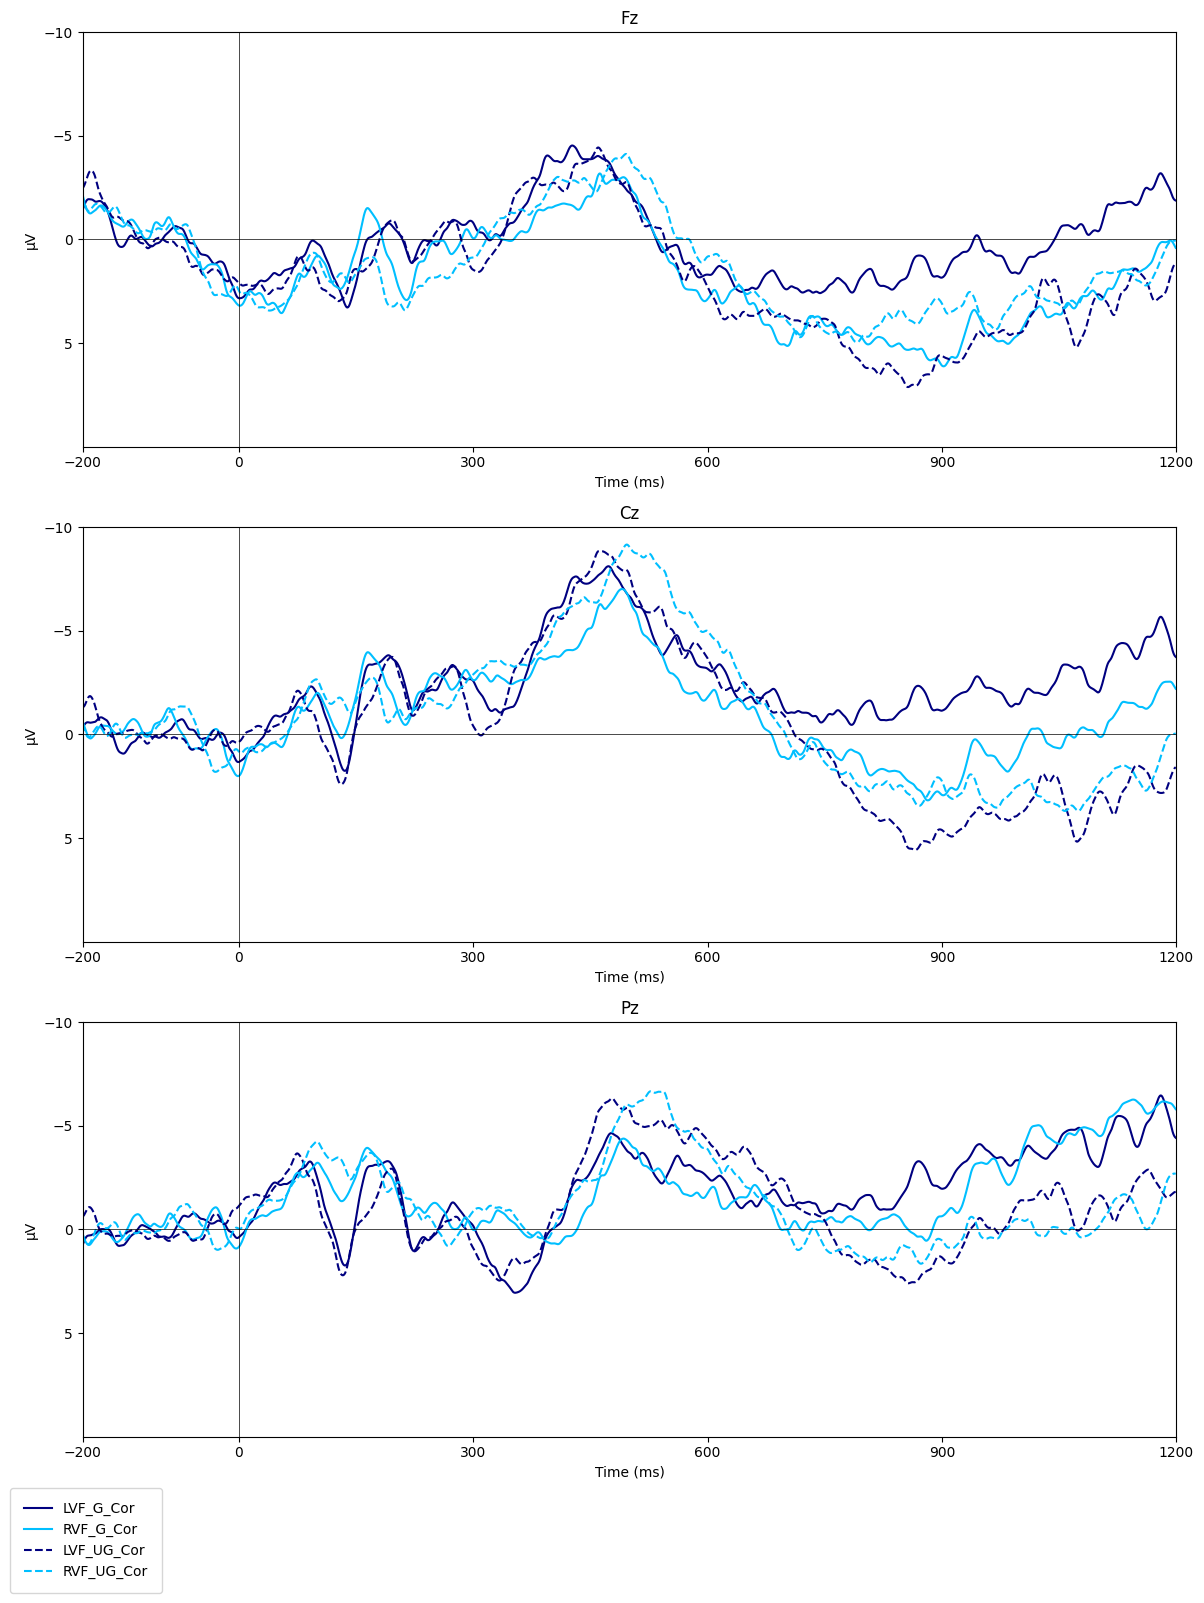

In [8]:
my_plots(evoked_wrapper, layout='Classic ERP',
         ch_to_plot=['Fz','Cz','Pz'], bins_to_plot=['LVF_G_Cor', 'RVF_G_Cor', 'LVF_UG_Cor', 'RVF_UG_Cor'],
        linestyles=['solid', 'solid', 'dashed', 'dashed'], colors=['navy', 'deepskyblue', 'navy', 'deepskyblue'],
        nrows=3, ncols=1, figsize=(12,15), xlim=(-200,1200), ylim=(-10,10),
        xticks=[-200,0,300,600,900,1200], yticks=list(range(-10,10,5)),
        loc='lower left', borderpad=1, bbox_to_anchor=[-0.005, -0.07],
        save=True)

Plot not saved... Please provide a valid file name to save the plot!


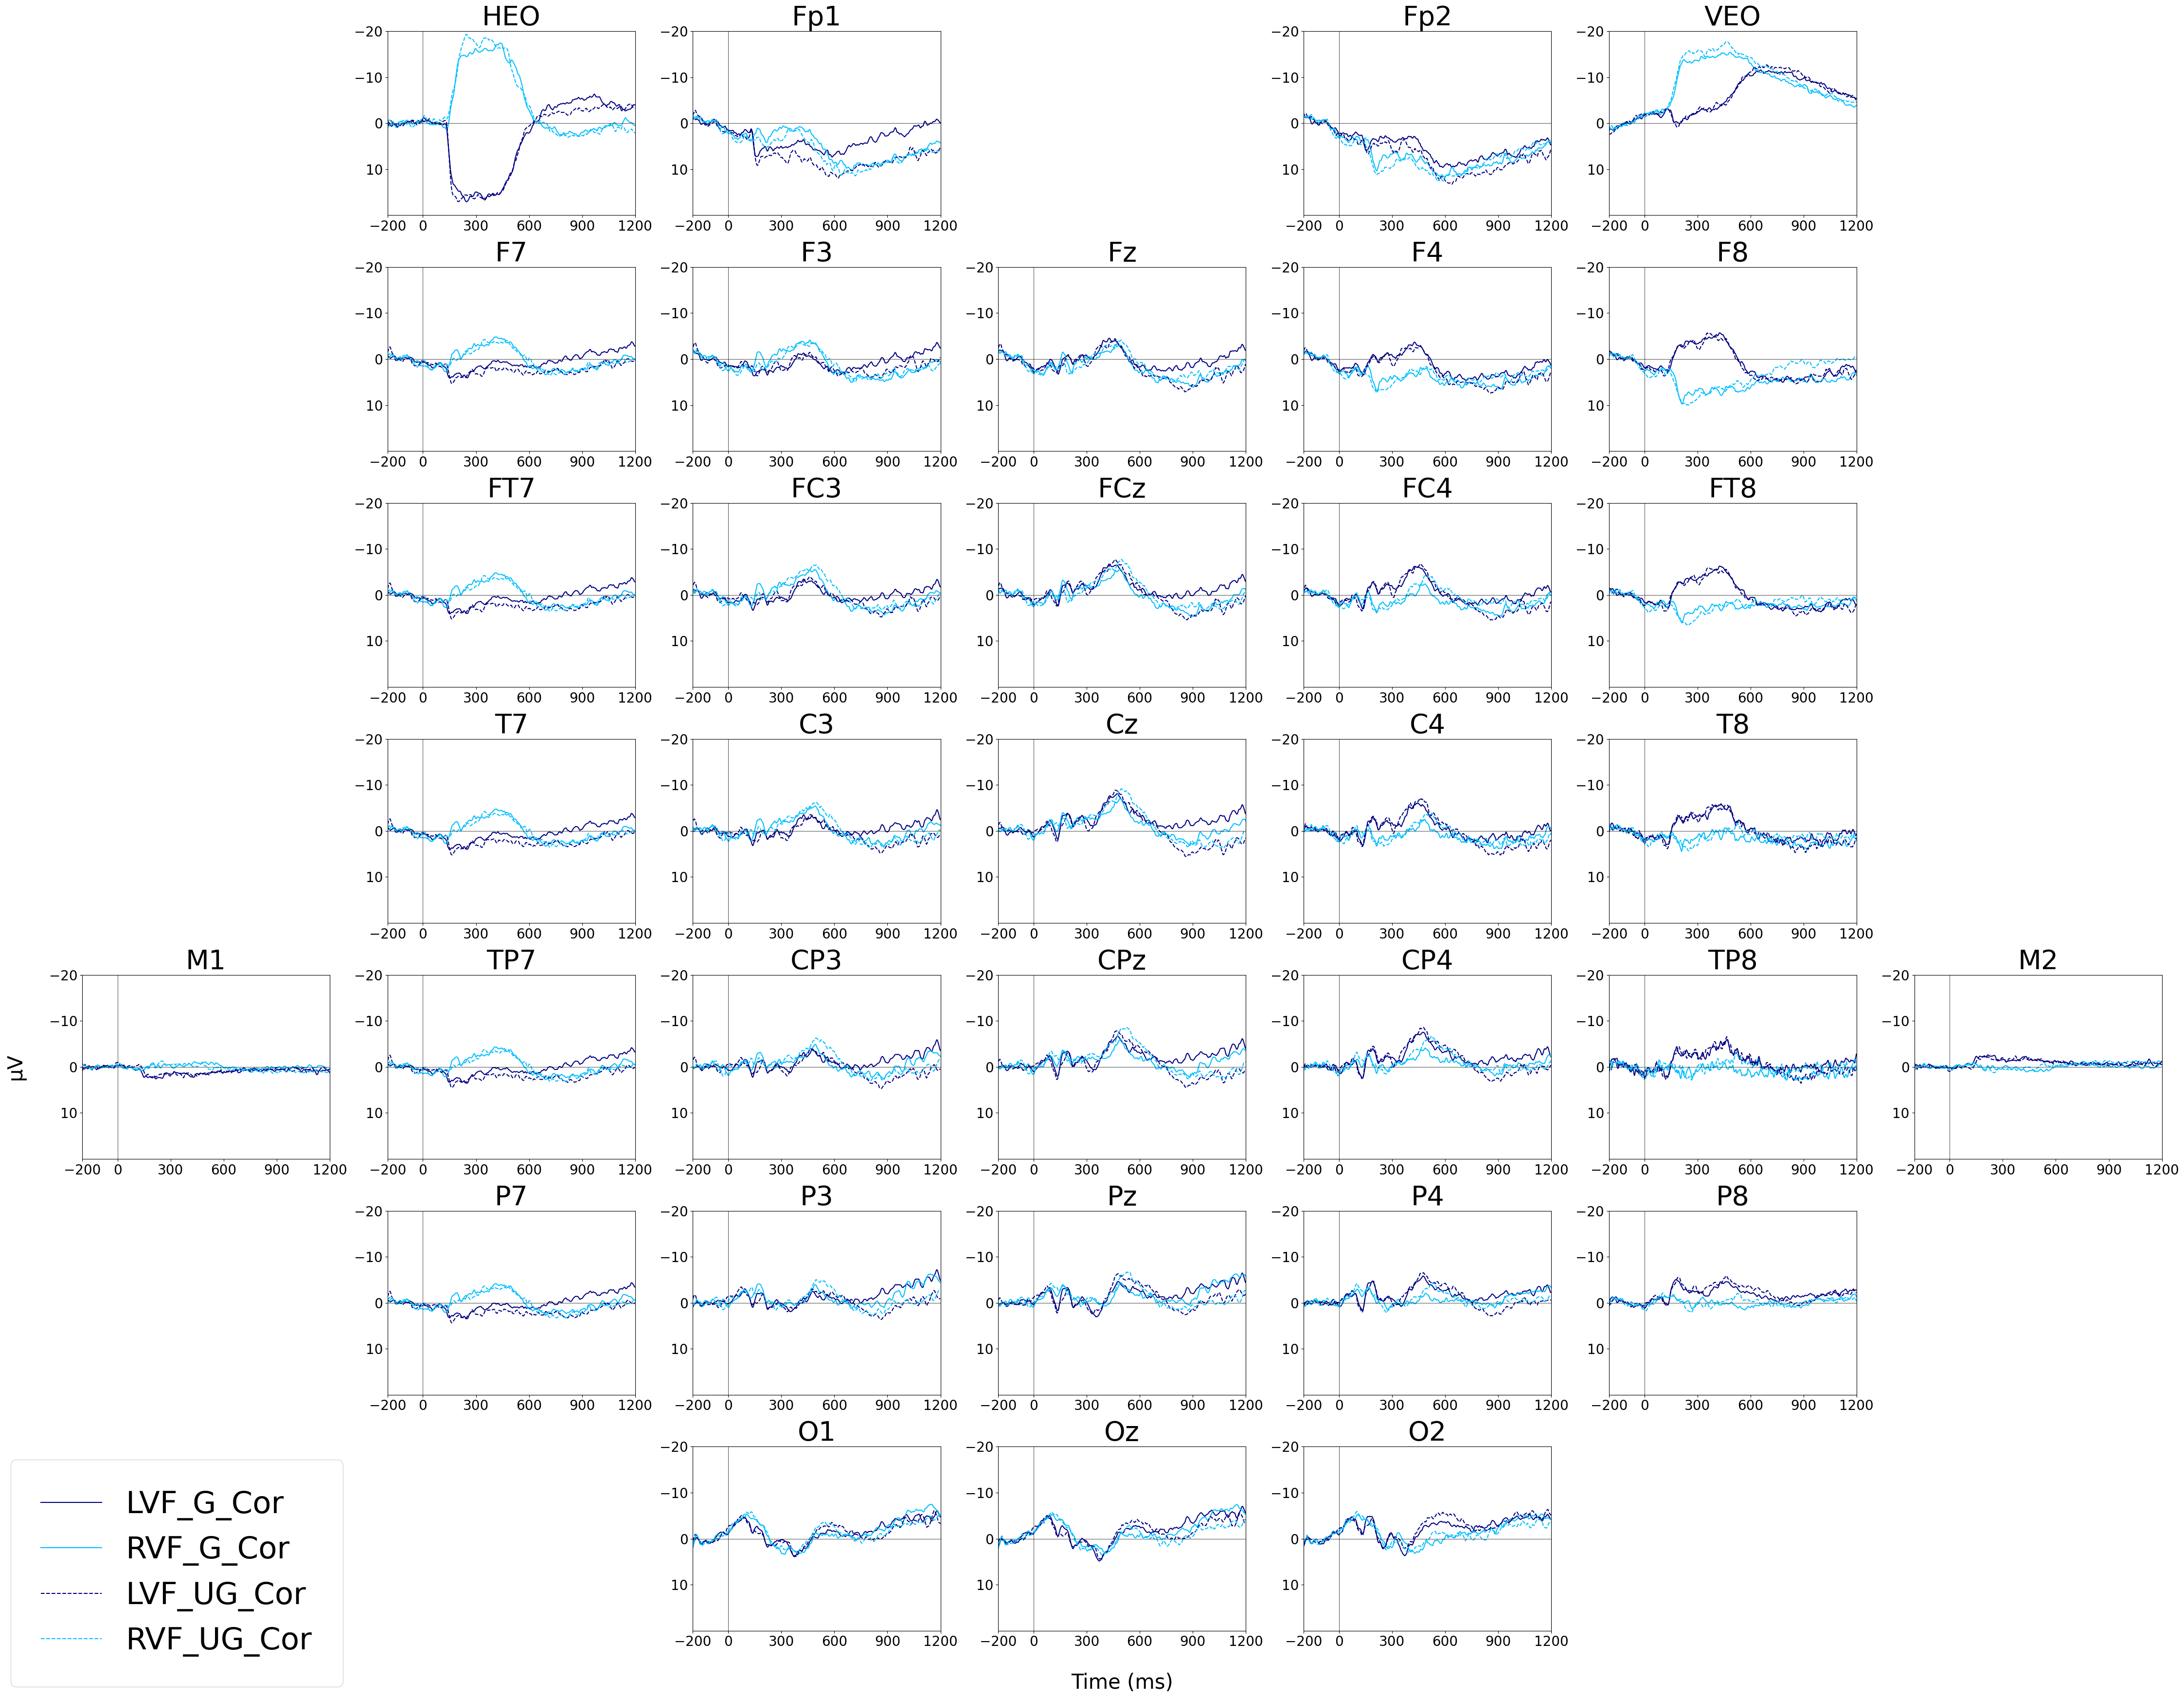

In [9]:
pos_dict = {'HEO':1,'Fp1':2,'Fp2':4,'VEO':5,
            'F7':8,'F3':9,'Fz':10,'F4':11,'F8':12,
            'FT7':15,'FC3':16,'FCz':17,'FC4':18,'FT8':19,
            'T7':22,'C3':23,'Cz':24,'C4':25,'T8':26,
            'M1':28,'TP7':29,'CP3':30,'CPz':31,'CP4':32,'TP8':33,'M2':34,
            'P7':36,'P3':37,'Pz':38,'P4':39,'P8':40,
            'O1':44,'Oz':45,'O2':46}
ch_to_plot = evoked_wrapper.ch_names

my_plots(evoked_wrapper, layout='Topo', pos_dict=pos_dict, ylabel_pos=28,
         ch_to_plot=ch_to_plot, bins_to_plot=['LVF_G_Cor', 'RVF_G_Cor', 'LVF_UG_Cor', 'RVF_UG_Cor'],
         linestyles=['solid', 'solid', 'dashed', 'dashed'], colors=['navy', 'deepskyblue', 'navy', 'deepskyblue'],
         nrows=7, ncols=7, figsize=(45,35), xlim=(-200,1200), ylim=(-20,20),
         xticks=list([-200,0,300,600,900,1200]), yticks=list(list(range(-20,20,10))),
         loc='lower left', borderpad=1, bbox_to_anchor=[-0.001, -0.001],
         save=True)

### Difference waves: (Ungrammatical Correct) - (Grammatical Correct)

In [10]:
diff_evoked_wrapper = create_bin_op_evoked_wrapper(evoked_wrapper,
                                                   bin_op_weights={'UG_Cor;G_Cor':[1,-1],
                                                                   'LVF_G_Cor;LVF_UG_Cor':[63/125,62/125],
                                                                   'RVF_G_Cor;RVF_UG_Cor':[66/131,65/131]},
                                                   new_binlabels=['UG_Cor - G_Cor', 'All_LVF_Cor', 'All_RVF_Cor'])

In [11]:
for i in diff_evoked_wrapper.evokeds:
    display(i)

# What is Number of averaged epochs?

<Evoked | 'unknown - unknown' (average, N=0.5), -0.2 – 1.199 s, baseline off, 34 ch, ~415 kB>

<Evoked | '0.504 × unknown + 0.496 × unknown' (average, N=1.9998720081914756), -0.2 – 1.199 s, baseline off, 34 ch, ~415 kB>

<Evoked | '0.504 × unknown + 0.496 × unknown' (average, N=1.9998834634657967), -0.2 – 1.199 s, baseline off, 34 ch, ~415 kB>

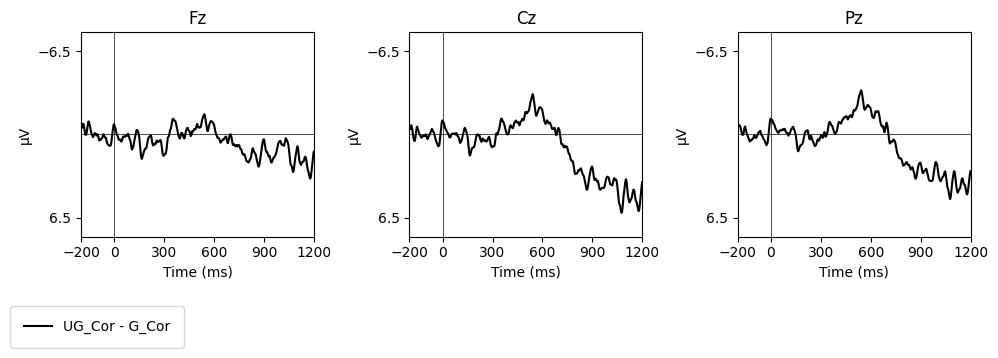

In [12]:
my_plots(diff_evoked_wrapper, layout='Classic ERP',
        ch_to_plot=['Fz','Cz','Pz'], bins_to_plot=['UG_Cor - G_Cor'],
        linestyles=['solid'], colors=['black'],
        nrows=1, ncols=3, figsize=(10,3), xlim=(-200,1200), ylim=(-8,8),
        xticks=[-200,0,300,600,900,1200], yticks=[-6.5,6.5],
        loc='lower left', borderpad=1, bbox_to_anchor=[-0.0001, -0.2], save=False)

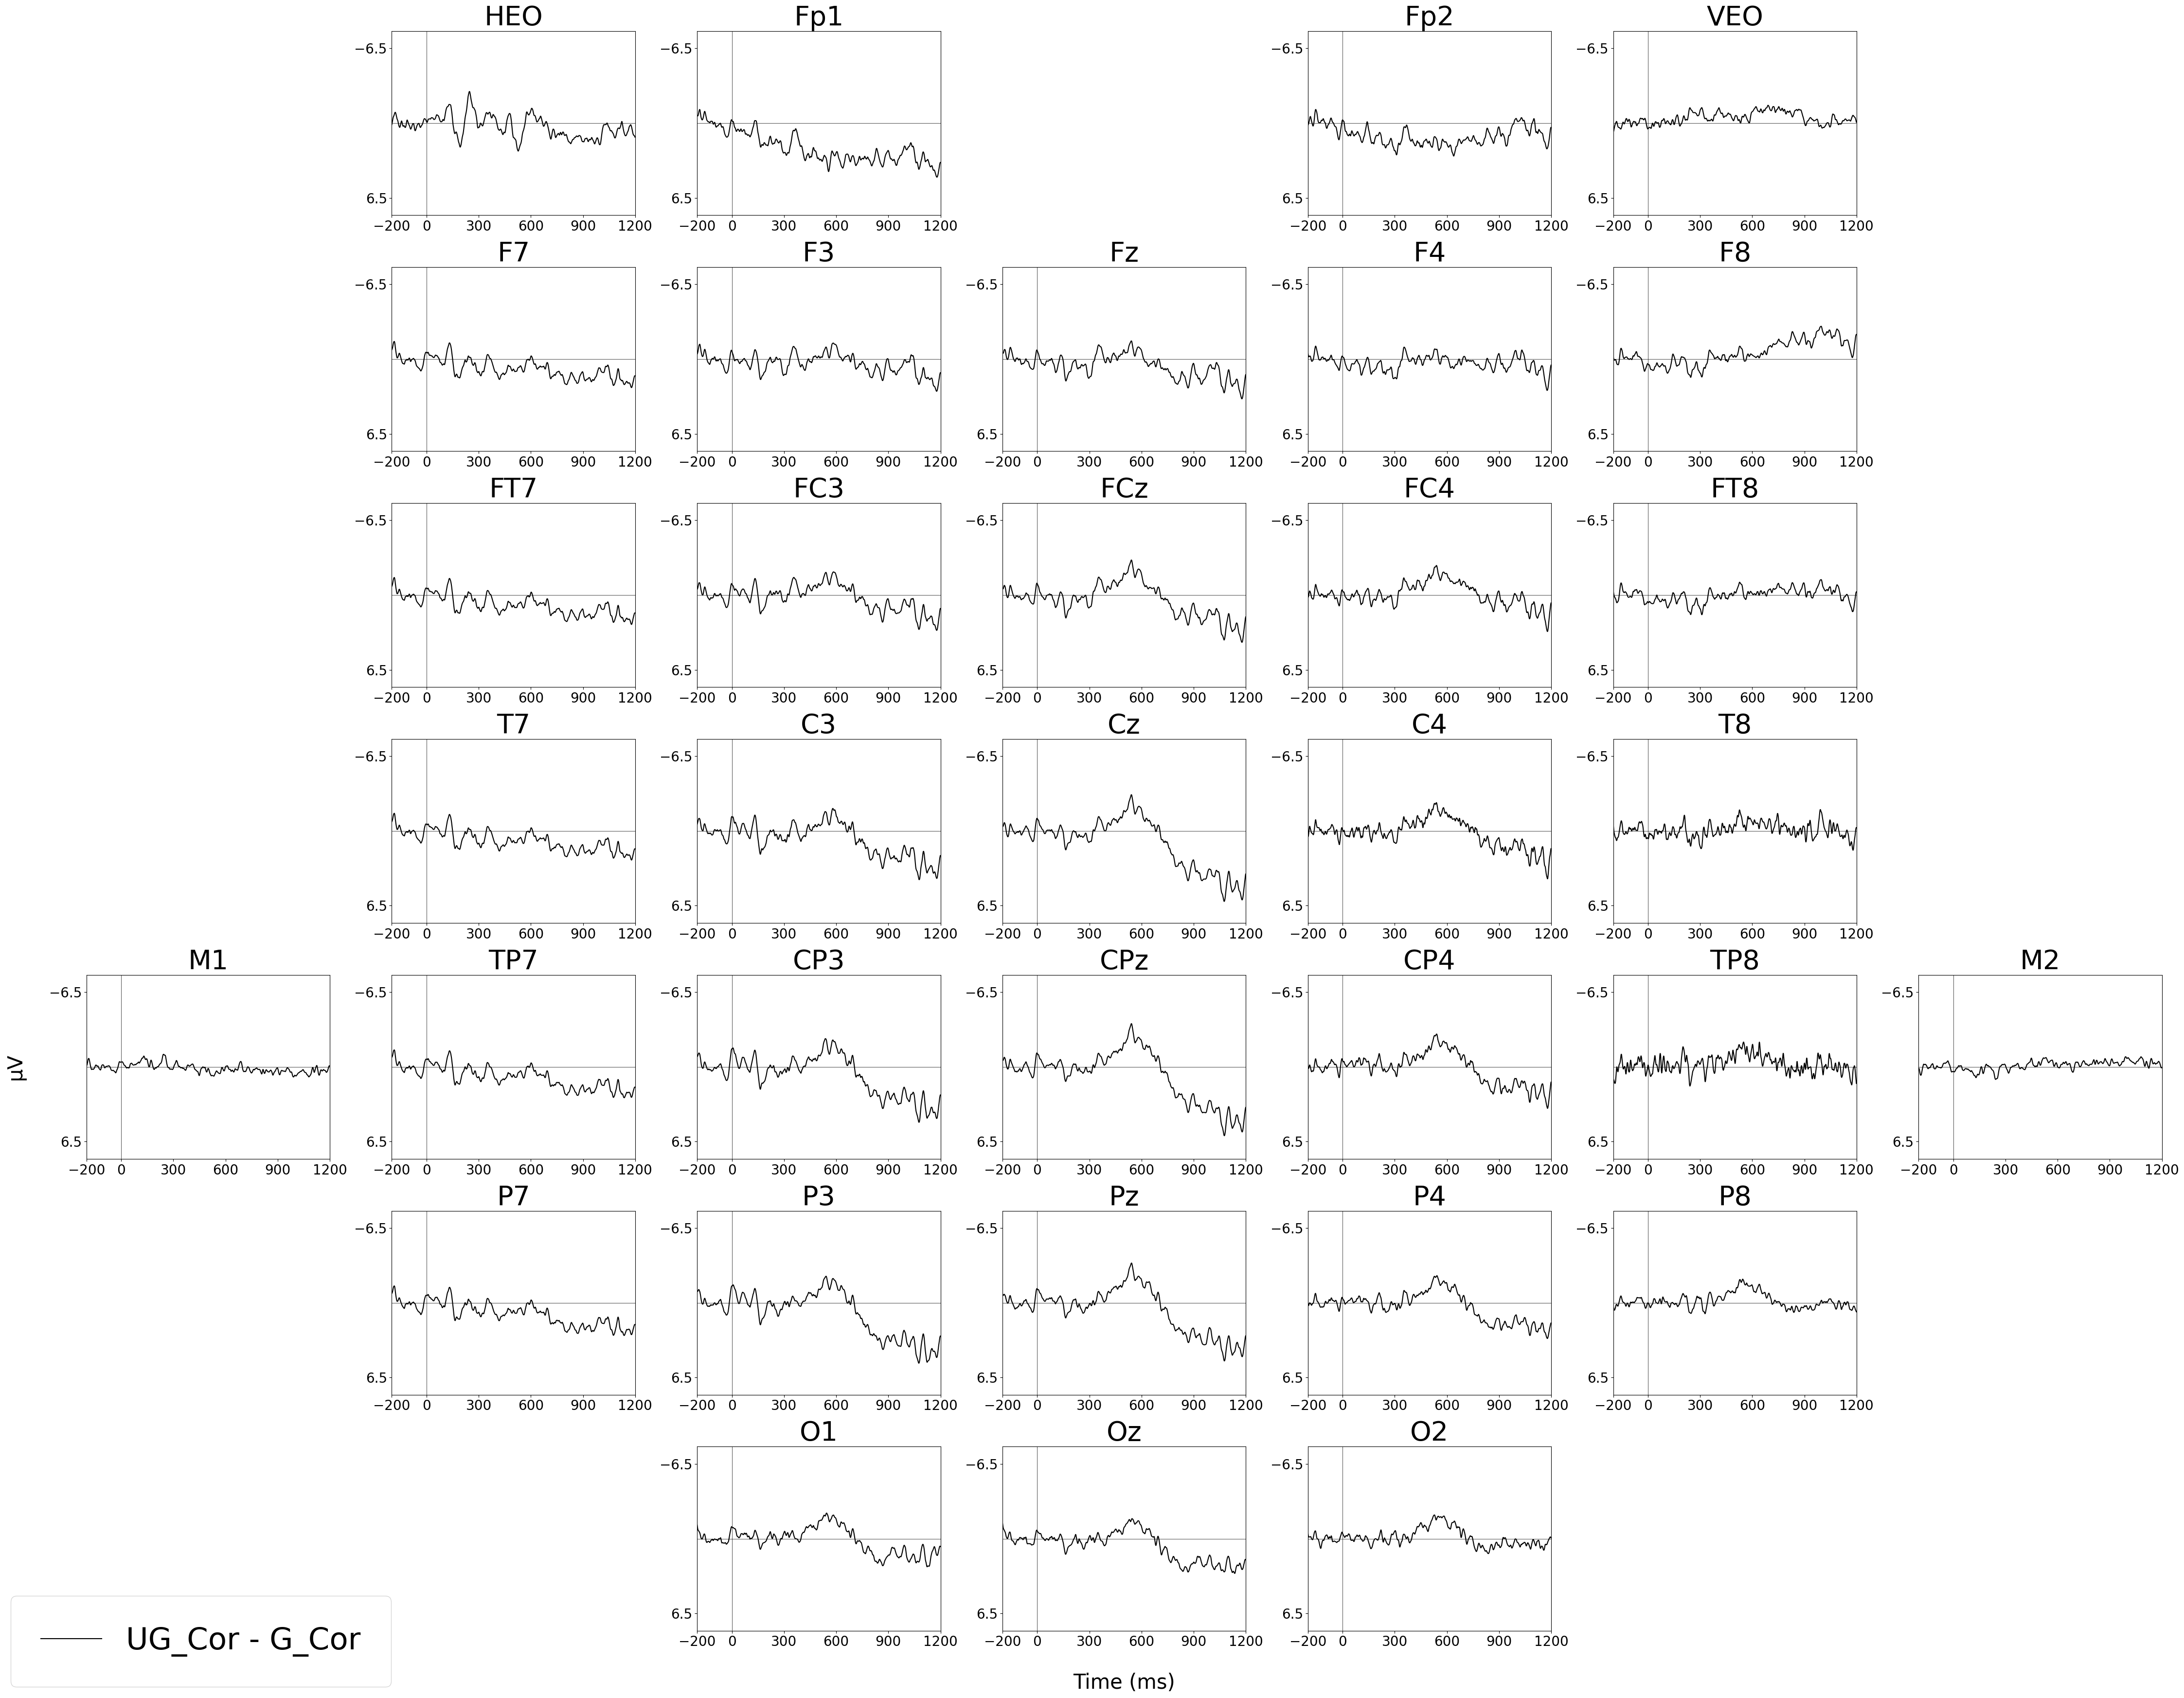

In [13]:
my_plots(diff_evoked_wrapper, layout='Topo', pos_dict=pos_dict, ylabel_pos=28,
         ch_to_plot=ch_to_plot, bins_to_plot=['UG_Cor - G_Cor'],
         linestyles=['solid'], colors=['black'],
         nrows=7, ncols=7, figsize=(45,35), xlim=(-200,1200), ylim=(-8,8),
         xticks=list([-200,0,300,600,900,1200]), yticks=[-6.5,6.5],
         loc='lower left', borderpad=1, bbox_to_anchor=[-0.001, -0.001],
         save=False)

### Difference waves: (Contralateral) - (Ipsilateral)

In [14]:
ch_dict = {}
for i, x in enumerate(diff_evoked_wrapper.ch_names):
    ch_dict[x] = i

contra_ipsi_evoked_wrapper = create_contra_ipsi_evoked_wrapper(diff_evoked_wrapper, 
                                                               bins_to_compare=['All_RVF_Cor', 'All_LVF_Cor'],
                                                               groups={'TP7-TP8': [ch_dict['TP7'], ch_dict['TP8']],
                                                                       'TP8-TP7': [ch_dict['TP8'], ch_dict['TP7']]})

In [15]:
contra_ipsi_evoked_wrapper.ch_names

['TP7-TP8', 'TP8-TP7']

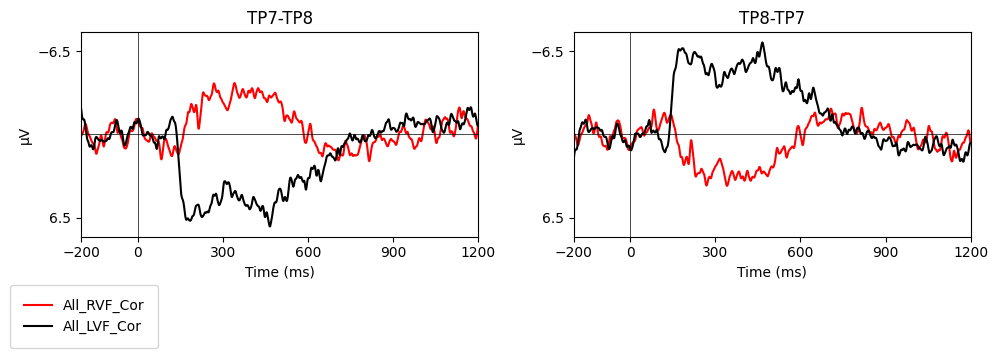

In [16]:
my_plots(contra_ipsi_evoked_wrapper, layout='Classic ERP',
        ch_to_plot=contra_ipsi_evoked_wrapper.ch_names,
        bins_to_plot=list(contra_ipsi_evoked_wrapper.bins.keys()),
        linestyles=['solid','solid'], colors=['red','black'],
        nrows=1, ncols=2, figsize=(10,3), xlim=(-200,1200), ylim=(-8,8),
        xticks=[-200,0,300,600,900,1200], yticks=[-6.5,6.5],
        loc='lower left', borderpad=1, bbox_to_anchor=[-0.0001, -0.2], save=False)

### Topo maps: (Ungrammatical Correct) - (Grammatical Correct)

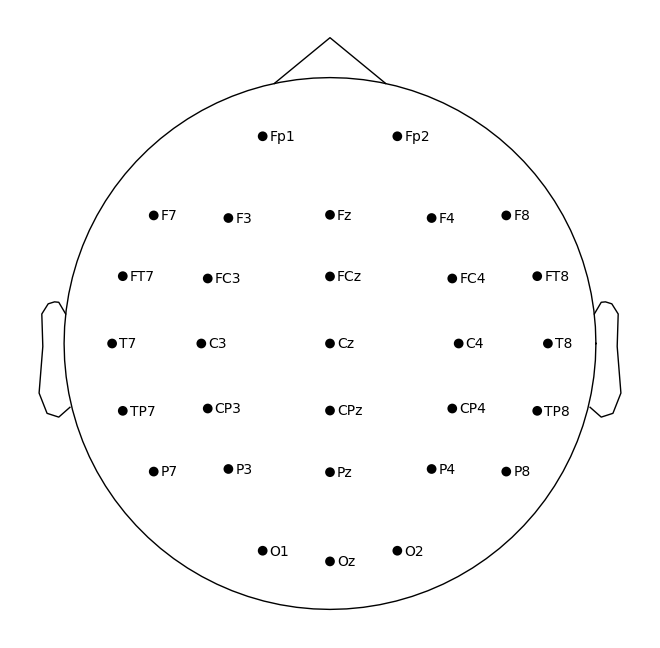

In [17]:
# Cutting off the 200-ms baseline; scale by 1e-06
diff_data = 1e-06*diff_evoked_wrapper.data[diff_evoked_wrapper.bins['UG_Cor - G_Cor']][:,200:]
evoked_topo = mne.EvokedArray(data=diff_data, info=info)

montage = evoked_topo.get_montage()
montage.plot();

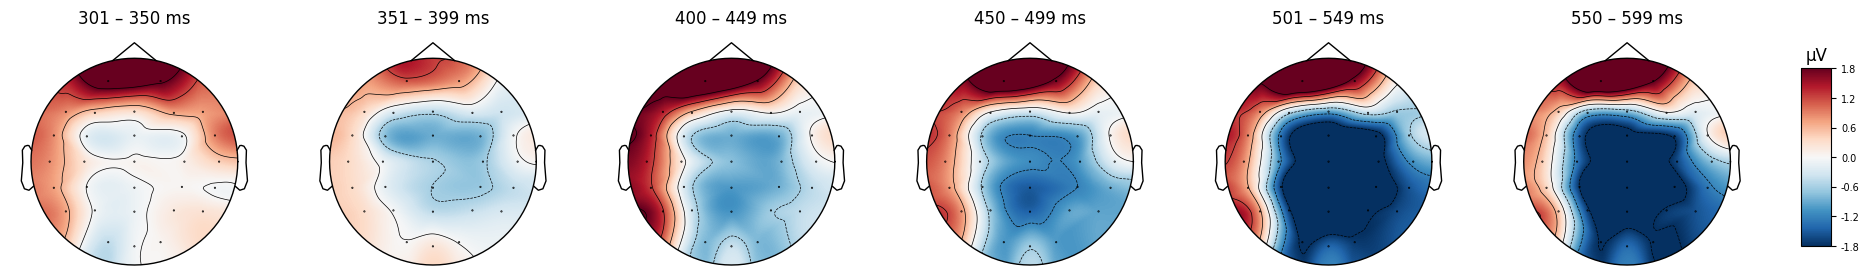

In [18]:
# N400 (300ms - 500ms)
evoked_topo.plot_topomap(times=np.array([325+i*50 for i in range(0,6)])/1000, average=[0.05]*6,
                         vlim=(-1.8,1.8), time_unit='ms', size=2, res=128, mask=None, contours=5);

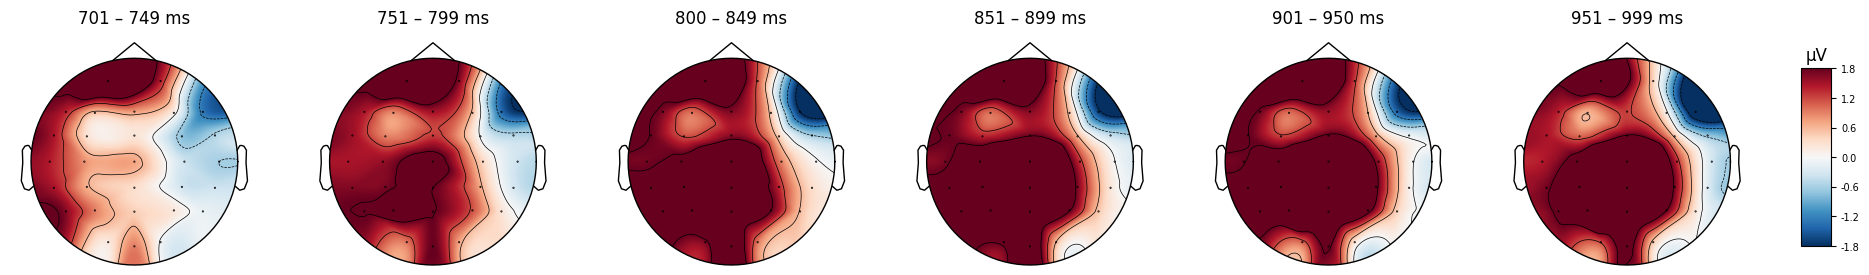

In [19]:
# P600 (700ms - 1000ms)
evoked_topo.plot_topomap(times=np.array([725+i*50 for i in range(0,6)])/1000, average=[0.05]*6,
                          time_unit='ms', vlim=(-1.8, 1.8), size=2, res=128, mask=None, contours=5);

### Exercise: Grand Average? 